# Building a Decision Tree from Scratch:

In [1]:
import numpy as np
import pandas as pd
#Importing collections' Counter to check for most common occurrence of a label in a leaf node without manually writing a loop:
from collections import Counter

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def IsLeafNode(self):
        return self.value is not None

In [3]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=3, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        
    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        #print("The number of features identified for decision tree is: ", self.n_features)
        self.root = self._grow_tree(X,y)
        
    def _grow_tree(self, X, y, depth = 0):
        #print("Called the function grow tree.")
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        #Checking stopping criteria:
        if (depth>=self.max_depth or n_labels == 1 or n_samples<self.min_samples_split):
            if(len(y)==0):
                #Placeholder, very rare case that a node is actually created with no values in it.
                return Node(value=0)
            leaf_value = self._most_common_label(y)
            #print("Called the function to evaluate most common label. This function uses the Counter object from collections python library.")
            return Node(value = leaf_value)

        #Here, both n_feats and self.n_features have 5 features. So, they essentially pick all features for building the decision tree.
        #This would come handy in random forests though, hence it has been implemented here.
        feat_idxs = np.random.choice(n_feats, self.n_features, replace = False)

        #Finding the best possible split in order to minimise gini (and maximise info gain) at every level:
        best_feature, best_thresh = self._best_split(X,y,feat_idxs)

        #Now that threshold has been obtained, creating left and right (yes and no) child nodes:
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


        
    def _best_split(self,X,y,feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            #print(feat_idx)
            X_column = X[0:-1, feat_idx]
            thresholds = np.unique(X_column)
            #Calculate info gain:
            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr
        #print(f"Best Feature: {split_idx}, Best Threshold: {split_threshold}")
        #print(f"Best Split has been found with info gain {best_gain}.This function ends here for the iteration.")
        
        return split_idx, split_threshold


    def _information_gain(self, y, X_column, thr):
        #Infomation gain = (Gini Impurity of Parent) - (Gini Impurity of Child Nodes):
        parent_gini = self._gini(y)

        #Creating child nodes:
        left_idxs, right_idxs = self._split(X_column, thr)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # Calculating the weighted avg. gini impurity of children:
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        gini_l, gini_r = self._gini(y[left_idxs]), self._gini(y[right_idxs])
        child_gini = (n_l/n) * gini_l + (n_r/n) * gini_r

        # Calculate the Information Gain:
        information_gain = parent_gini - child_gini
        return information_gain


    def _gini(self, y):
        hist = np.bincount(y) # Creates a histogram with number of occurrences of every element.
        ps = hist / len(y) # Probability of every element in the bin.
        return (1 -np.sum(ps ** 2)) # Gini Index Formula

        
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs      

    
    def _most_common_label(self, y):
        counter = Counter(y)
        val = counter.most_common(1)[0][0] #the most repeated element in the most repeated tuple (of element&count) in 1st most repeated elems of node
        return val

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.IsLeafNode():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

In [4]:
df = pd.read_csv("Loans.csv")
df1= df.drop('loan_approved', axis = 1)
labels = df['loan_approved']
df1 = pd.get_dummies(df1).to_numpy()
labels = labels.to_numpy().ravel()


In [5]:
decisiontree = DecisionTree()
decisiontree.fit(df1, labels)

In [6]:
test_df = pd.read_csv("Loans_Test.csv")
test_df1= test_df.drop('loan_approved', axis = 1)
test_labels = test_df['loan_approved']
test_df1 = pd.get_dummies(test_df1).to_numpy()
test_labels = test_labels.to_numpy().ravel()

test_labels
test_df1

array([[3.200000e+01, 1.054055e+04, 4.390000e+02, 1.000000e+00,
        1.000000e+00],
       [2.500000e+01, 3.442942e+04, 3.200000e+02, 1.000000e+00,
        1.000000e+00],
       [6.200000e+01, 4.475290e+03, 4.480000e+02, 4.000000e+00,
        1.000000e+00],
       ...,
       [3.900000e+01, 1.619469e+04, 4.600000e+02, 2.000000e+00,
        1.000000e+00],
       [5.200000e+01, 3.873991e+04, 7.260000e+02, 2.000000e+00,
        1.000000e+00],
       [2.400000e+01, 1.127855e+04, 7.020000e+02, 0.000000e+00,
        0.000000e+00]], shape=(201, 5))

In [7]:
#y_pred = np.array([decisiontree.predict(x) for x in test_df1])
y_pred = decisiontree.predict(test_df1)
y_pred

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1])

In [8]:
test_labels

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1])

## Function to calculate F1 Score:
F1 score is given by (2 * Precision * Recall) / (Precision + Recall)  
Precision = TP / (TP + FP)  
Recall = TP / (TP + FN)

In [9]:
def f1_score(actual, predicted):
    #Here x is the actual test label array and y is the predicted label array.
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(len(actual)):
        if actual[i] == 1 and predicted[i] == 1:
            tp += 1
        elif actual[i] == 0 and predicted[i] == 1:
            fp += 1
        elif actual[i] == 1 and predicted[i] == 0:
            fn += 1
        else:
            tn += 1

    precision = tp / (tp + fp)
    recall = tp/ (tp + fn)
    f1_score = ( 2 * precision * recall ) / (precision + recall)
    return f1_score

In [10]:
#Training data accuracy:
preds = decisiontree.predict(df1)
f1_score(labels,preds)

0.9156999226604795

In [11]:
#Testing data accuracy:
f1_score(test_labels, y_pred)

0.9127906976744187

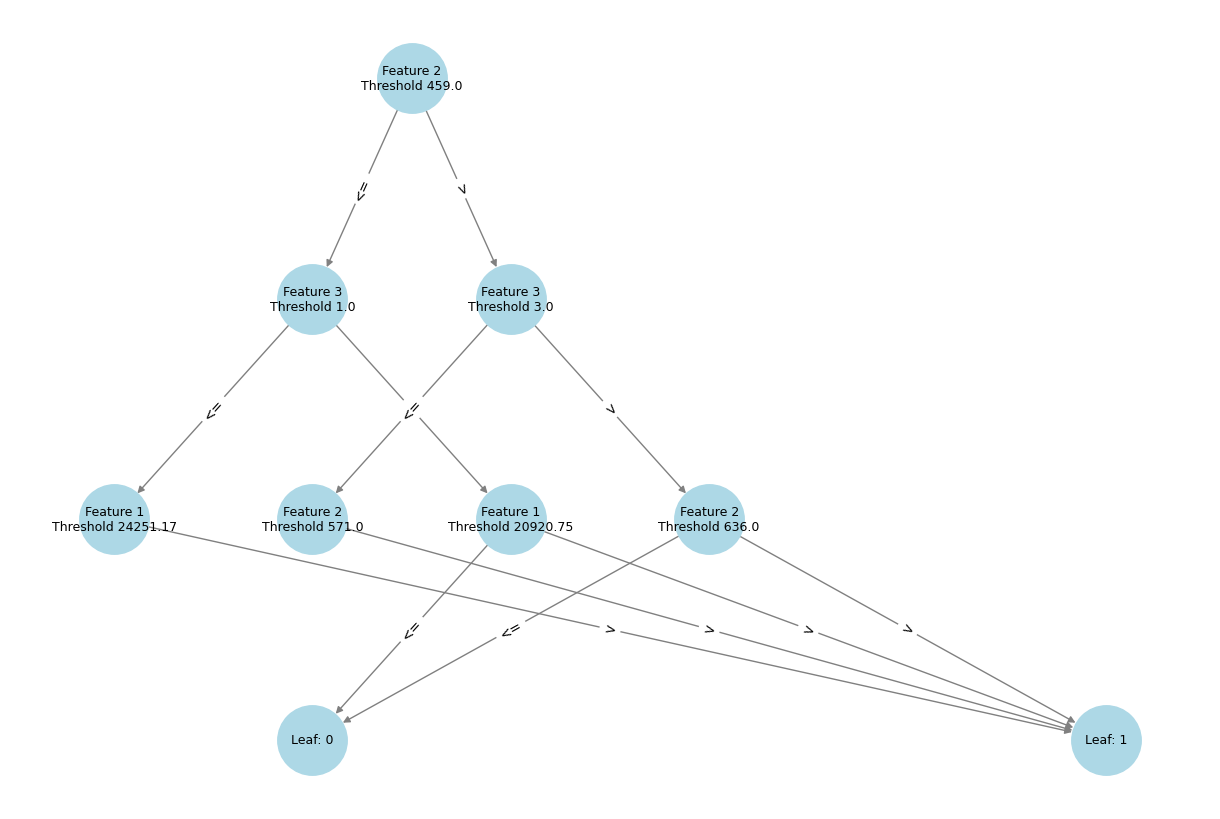

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_tree(node, graph=None, pos=None, parent=None, edge_label=None, x=0, y=0, depth=1, index=0, total_nodes_at_depth=None):
    if graph is None:
        graph = nx.DiGraph()
        pos = {}
        total_nodes_at_depth = get_node_counts(node)  # Get node distribution at each level
    
    node_label = f"Feature {node.feature}\nThreshold {node.threshold}" if not node.IsLeafNode() else f"Leaf: {node.value}"
    graph.add_node(node_label)
    
    num_nodes = total_nodes_at_depth.get(depth, 1)
    x_position = index - (num_nodes - 1) / 2  # Center nodes at each depth level
    pos[node_label] = (x_position, -depth)
    
    if parent is not None:
        graph.add_edge(parent, node_label, label=edge_label)
    
    if not node.IsLeafNode():
        left_count = total_nodes_at_depth.get(depth + 1, 2) // 2
        plot_tree(node.left, graph, pos, node_label, "<=", x, y, depth + 1, index, total_nodes_at_depth)
        plot_tree(node.right, graph, pos, node_label, ">", x, y, depth + 1, index + left_count, total_nodes_at_depth)
    
    return graph, pos

def get_node_counts(node, depth=1, counts=None):
    if counts is None:
        counts = {}
    if node is None:
        return counts
    
    counts[depth] = counts.get(depth, 0) + 1
    if not node.IsLeafNode():
        get_node_counts(node.left, depth + 1, counts)
        get_node_counts(node.right, depth + 1, counts)
    
    return counts

def draw_tree(root):
    graph, pos = plot_tree(root)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_size=2500, node_color='lightblue', font_size=9, edge_color='gray')
    edge_labels = {(u, v): d['label'] for u, v, d in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10)
    plt.show()

# Drawing the Tree:
draw_tree(decisiontree.root)


# Building a Decision Tree using SKLearn:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Loans.csv")
df1= df.drop('loan_approved', axis = 1)
labels = df['loan_approved']
df1 = pd.get_dummies(df1).to_numpy()
labels = labels.to_numpy().ravel()

In [3]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(df1, labels)

DecisionTreeClassifier(random_state=0)

In [4]:
test_df = pd.read_csv("Loans_Test.csv")
test_df1= test_df.drop('loan_approved', axis = 1)
test_labels = test_df['loan_approved']
test_df1 = pd.get_dummies(test_df1).to_numpy()
test_labels = test_labels.to_numpy().ravel()

In [5]:
y_pred = clf.predict(test_df1)

In [6]:
from sklearn.metrics import f1_score

print("F1 Score:", f1_score(test_labels, y_pred, average="weighted"))


F1 Score: 0.8670140152894067
